In [154]:
import deeplake
import matplotlib.pyplot as plt
import os
import cv2, numpy, vptree, PIL
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms, models
import time
import tensorflow as tf
import faiss

In [155]:
def plot_image(img):
    if (len(img.shape) == 2):
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [156]:
def plot_many(images):
    num_images = len(images)
    
    # Create a figure and axis objects
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    
    # Plot each image
    for i, image in enumerate(images):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
    
    # Show the plot
    plt.show()


In [157]:
# turns image into the shape (x, x, 3)
def reorient_channels(img):
    if len(img.shape) == 2:
        return img
    if len(img.shape) != 3:
        raise Exception("Image does not have 2 or 3 channels")

    # color_channel = img.shape.index(3)
    channels = [-1, -1, -1]
    shape = img.shape
    for i in range(3):
        if shape[i] == 3:
            channels[2] = i
        else:
            idx = channels.index(-1)
            channels[idx] = i
            
    # print(channels)
    correct = tf.transpose(img, [channels[0], channels[1], channels[2]])
    return correct

In [158]:
def canny_edge_detection(image, val):
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Convert to np.uint8
    blurred_image_uint8 = np.uint8(blurred_image * 255)
    
    # Perform Canny edge detection
    edges = cv2.Canny(blurred_image_uint8, val, val * 2)
    
    return edges

In [159]:
edges = torch.load('edges.pt')
og = torch.load('og.pt')

In [160]:
def canny(img, thresh1, thresh2):
    img_uint8 = (img.numpy() * 255).astype(np.uint8)
    return cv2.Canny(img_uint8, thresh1, thresh2)

In [163]:
canny_edges = []

for i in range(len(edges)):
    val = 30
    scaled = (edges[i].numpy() * 255).astype('uint8')
    canny = canny_edge_detection(reorient_channels(og[i]).numpy(), 100)
    canny_edges.append(canny)
    # plot_many([edges[i], cv2.Canny(scaled, val, 2 * val), reorient_channels(og[i]), canny_edge_detection(reorient_channels(og[i]).numpy(), 100)])

In [164]:
print(len(canny_edges), type(canny_edges), type(canny_edges[0]))

320 <class 'list'> <class 'numpy.ndarray'>


In [217]:
contours, hierarchy = cv2.findContours(canny_edges[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contour_list = []

for contour in contours:
    if cv2.contourArea(contour) > 35 and cv2.arcLength(contour,-1) > 100:
        contour_list.append(contour)

In [218]:
len(contour_list)

4

In [267]:
descriptor_list = []

for i in range(len(canny_edges)):
    contours, hierarchy = cv2.findContours(canny_edges[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_list = []
    for contour in contours:
        if cv2.contourArea(contour) > 35 and cv2.arcLength(contour,-1) > 100:
            contour_list.append(contour)
        
    for idx,item in enumerate(contour_list):
        points_tensor = torch.from_numpy(contour_list[idx][:,0,:])
        centroid = points_tensor.float().mean(dim=0)
        centered_points = (points_tensor - centroid).to(torch.float64)
        cnt1 = centered_points.numpy()
        scale = np.max(np.abs(cnt1))
        # print(scale)
        cnt1 /= scale
        dft = np.fft.fft(cnt1[:, 0] + 1j * cnt1[:, 1])
        descriptors = dft[:10]
        real_vectors = np.concatenate((np.real(descriptors), np.imag(descriptors)), axis=0)
        descriptor_list.append(real_vectors)

In [268]:
a = torch.tensor(np.array(descriptor_list))
a.shape

torch.Size([684, 20])

In [259]:
min_length = 10000
min_index = 10000
for i, descriptor in enumerate(descriptor_list):
    length = len(descriptor)
    if length < min_length:
        min_length = length
        min_index = i

print("Index of minimum length descriptor:", min_index)
print("Minimum length:", min_length)

Index of minimum length descriptor: 39
Minimum length: 10


In [129]:
contour = contours[4][:, 0, :]
# print(contour)
centroid = np.mean(contour[0], axis=0)
# print(centroid)
normalized_contour = contour - centroid
# print(normalized_contour)
scale = np.max(np.abs(normalized_contour))
normalized_contour /= scale
# print(normalized_contour)

# Compute DFT
dft = np.fft.fft(normalized_contour[:, 0] + 1j * normalized_contour[:, 1])

# Select descriptors (e.g., first 10 coefficients)
descriptors = dft[:5]
print(descriptors)

[-62.10416667+95.45833333j  -4.77384435 +5.81121127j
  -3.49062905 -1.46771675j  -0.17201648 -3.91306889j
   1.41958211 +0.41147366j]


In [179]:
# output_dir = 'test'
# tensor = torch.zeros(len(contours), 128, 128)
# for i, contour in enumerate(contours):
#     arr = np.array(sublist)
#     #print(arr)

#     min_x = np.min(arr[:, :, 0])  # Minimum of the first digit (x-coordinate)
#     min_y = np.min(arr[:, :, 1])  # Minimum of the second digit (y-coordinate)
#     arr[:, :, 0] -= min_x
#     arr[:, :, 1] -= min_y

#     arr = arr.reshape(-1, 2)
    
#     y_indices = contour[:, 0, 1]  # Extract y-coordinates
#     x_indices = contour[:, 0, 0]  # Extract x-coordinates
#     tensor[i, y_indices, x_indices] = 1
#     arr = tensor[i].numpy()

#     # Define the filename for the np file
#     filename = os.path.join(output_dir, f"array_{i}.jpg")
#     metadata_filename = os.path.join(output_dir, f"array_{i}.dat")
#     min_coords = np.array([min_x, min_y])
    
    
#     # Save the numpy array to the file
#     # np.save(filename, arr)
#     cv2.imwrite(filename, arr)
#     # np.save(metadata_filename, min_coords)

In [109]:
for i, contour in enumerate(contours):
    contour_shape = contours[0].shape
    # 
    # Create a zero array with the same shape as contours[0], plus an additional dimension
    contour_image = np.zeros((1,) + contour_shape, dtype=np.uint8)

    # Draw the current contour on the blank image
    cv2.drawContours(contour_image, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)

    # Save the contour image to a separate file
    contour_filename = os.path.join(output_dir, f'contour_{i}.jpg')
    cv2.imwrite(contour_filename, contour_image)


error: OpenCV(4.9.0) /io/opencv/modules/core/src/matrix_c.cpp:190: error: (-5:Bad argument) Unknown array type in function 'cvarrToMat'


In [88]:
tensor[0].shape

torch.Size([128, 128])

In [183]:
im = canny_edges[4].numpy()
assert im is not None, "file could not be read, check with os.path.exists()"
# imgray = cv2.cvtColor(im, cv.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv2.findContours(im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# contour_list = []

# for contour in contours:
#     if cv2.contourArea(contour) > 35 and cv2.arcLength(contour,-1) > 100:
#         contour_list.append(contour)


In [184]:
# plot_image(cv2.drawContours(im, contouer_list, -1, (0,255,0), 3))

In [185]:
# np.where(canny_edges[2].numpy())

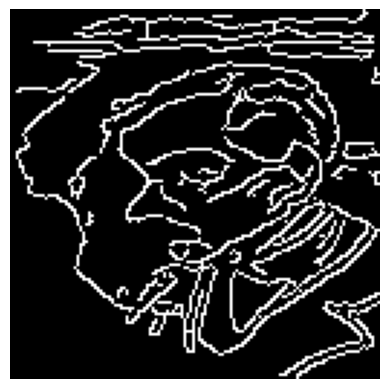

In [186]:
plot_image(im)

In [190]:
source_img = np.zeros((128, 128, 3), dtype=np.uint8)

# cv2.drawContours(source_img, contour_list, 3, (0,255,0), 1)

for idx, item in enumerate(contours):
    source_img = np.zeros((128, 128, 3), dtype=np.uint8)
    filename = os.path.join(output_dir, f"array_{idx}.jpg")
    cv2.imwrite(filename, cv2.drawContours(source_img, contours, idx, (0,255,0), 1))

In [188]:
print(len(contour_list))

3


In [198]:

# Create an empty tensor to store the binary masks
tensor_list = []

for idx, item in enumerate(contours):
    # Create a tensor of zeros with shape (128, 128)
    tensor = torch.zeros(128, 128)
    
    # Set the specified indices to 1
    for point in item:
        y, x = point[0]  # Extract y and x coordinates
        tensor[x, y] = 1  # Set the value at the specified indices to 1
    
    # Append the tensor to the tensor list
    tensor_list.append(tensor)

# Stack the tensors along a new dimension to create the ultimate tensor
ultimate_tensor = torch.stack(tensor_list)


In [199]:
print(ultimate_tensor[0][120])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


In [200]:
ultimate_tensor[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [97]:
arr = contours[0][:,-1]
# Create an empty boolean array
array = np.zeros((128, 128), dtype=int)

# Set coordinates to True
array[arr[:, 0], arr[:, 1]] = 1
array.shape

(128, 128)

In [98]:
rgb_image = np.expand_dims(array, axis=0)
rgb_image = np.repeat(rgb_image, 3, axis=0)
rgb_image = np.expand_dims(rgb_image, axis = 0)
rgb_image.shape

(1, 3, 128, 128)

In [180]:
# contour

In [136]:
print(np.expand_dims(descriptors, axis=0).shape)

(1, 5)


In [110]:
model_ft = models.resnet18(pretrained=True)
### strip the last layer
feature_extractor = torch.nn.Sequential(*list(model_ft.children())[:-1])
### check this works
x = torch.randn([1,3,224,224])
print(x.shape)

# print(x)
print(og[0].shape)
# print(og)
output = feature_extractor(torch.tensor(rgb_image).to(torch.int32)) # output now has the features corresponding to input x
print(output.shape)

torch.Size([1, 3, 224, 224])
(3, 128, 128)


RuntimeError: expected scalar type Int but found Float

In [221]:
nlist = 100
k = 4
quantizer = faiss.IndexFlatL2(d)  # the other index
index = faiss.IndexIVFFlat(quantizer, d, nlist)
assert not index.is_trained
index.train(a)
assert index.is_trained

index.add(a)                  # add may be a bit slower as well
# D, I = index.search(xq, k)     # actual search
# print(I[-5:])                  # neighbors of the 5 last queries
# index.nprobe = 10              # default nprobe is 1, try a few more
# D, I = index.search(xq, k)
# print(I[-5:])                  # neighbors of the 5 last queries


In [138]:
np.expand_dims(descriptors, axis=0).shape

(1, 5)

In [142]:
descriptors[0]

(-62.10416666666667+95.45833333333331j)

In [150]:
real_vectors = np.concatenate((np.real(descriptors), np.imag(descriptors)), axis=0)
real_vectors

(10,)